In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

from sklearn import model_selection
from PIL import Image
from skimage import exposure

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Datos

## Dataframe

In [3]:
path = '/home/maryskal/Downloads/archive/vinbigdata'
path = '/home/mr1142/Documents/Data/vinbigdata'

In [4]:
df = pd.read_csv(os.path.join(path, 'train.csv'))

In [5]:
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


In [6]:
for i, finding in enumerate(np.unique(df.class_name)):
    print(f'class name: {finding}')
    print(f'ID: {df.class_id[i]}')
    print(sum(df.class_name == finding))

class name: Aortic enlargement
ID: 14
7162
class name: Atelectasis
ID: 14
279
class name: Calcification
ID: 3
960
class name: Cardiomegaly
ID: 0
5427
class name: Consolidation
ID: 14
556
class name: ILD
ID: 11
1000
class name: Infiltration
ID: 5
1247
class name: Lung Opacity
ID: 8
2483
class name: No finding
ID: 0
31818
class name: Nodule/Mass
ID: 13
2580
class name: Other lesion
ID: 7
2203
class name: Pleural effusion
ID: 13
2476
class name: Pleural thickening
ID: 14
4842
class name: Pneumothorax
ID: 14
226
class name: Pulmonary fibrosis
ID: 0
4655


Creo la clase neumonía

In [7]:
values = ['Consolidation', 'Infiltration']
df['Neumonia'] = 0
index = [i for i, clase in enumerate(df.class_name) if clase in values]
df['Neumonia'][index] = 1

/home/mr1142/miniconda3/envs/init/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,Neumonia
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580,0
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159,0
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072,0


Divido el dataset en dos y reduzco el de no neumonía

In [9]:
df_neumo = df[df.Neumonia == 1].reset_index(drop=True)
df_no_neumo = df[df.Neumonia == 0].reset_index(drop=True)

In [10]:
print(len(df_neumo))
print(len(df_no_neumo))

1803
66111


Para reducir elijo un numero de valores aleatorios que serán los índices

In [11]:
selection = np.random.randint(0, len(df_no_neumo), len(df_neumo))
df_no_neumo = df_no_neumo.iloc[selection,:]
len(df_no_neumo)

1803

Genero el nuevo dataframe juntando

In [12]:
df = pd.concat([df_neumo, df_no_neumo]).reset_index(drop=True)

Reordeno aleatoriamente

In [13]:
df = df.sample(frac=1)

In [14]:
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,Neumonia
548,17d5b60d0b5decddb51eba55dc4a514b,Consolidation,4,R8,831.0,913.0,1216.0,1149.0,3072,3072,1
100,38791e51fbea01ae3935f311e8878f1c,Infiltration,6,R9,1923.0,1246.0,2212.0,1386.0,2540,3072,1
3344,7d0cc84e9002c1eb219559540c014e7a,Atelectasis,1,R10,674.0,417.0,1178.0,721.0,2712,3256,0
1216,eb319a3149253e25a32a6f2926cf67b2,Infiltration,6,R8,1452.0,549.0,1765.0,1020.0,2304,2880,1
2259,ab51ed37f90ea78c93f1e92aa8a9d749,Aortic enlargement,0,R9,1076.0,646.0,1303.0,954.0,2208,2624,0


## Imagenes

In [15]:
pixels = 256

In [16]:
def equalizar(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    # Equalization
    img_eq = exposure.equalize_hist(img)
    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)      
    return img_adapteq

In [17]:
def downsample(img):
    img = Image.fromarray(img)
    img = img.resize((pixels,pixels))
    img = np.array(img)
    img = img/255
    r = np.expand_dims(img, axis=-1)
    return r

In [18]:
def charge_img(name):
    img = Image.open(os.path.join(path, 'train', name + '.png'))
    img = np.array(img)
    img = equalizar(img)
    img = downsample(img)
    return(img)

In [19]:
tensor = np.zeros((len(df.image_id), pixels, pixels, 1))
for i in range(tensor.shape[0]):
    tensor[i,...] = charge_img(df.image_id[i])

## X e Y

In [20]:
Y = np.array(df['Neumonia'])
X = tensor

In [21]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, 
                                                                    random_state=42, shuffle=True, stratify=Y )

# Modelo

- Añado una capa inicial para poder entregarle el input de 3 canales. 
- Añado 1 convolución con max pooling y una segunda convolución cno globalMaxPooling para ajustar mejor
- Añado Dropout para evitar overfiting
- Añado la capa final con 6 neuronas de salida

In [22]:
input_shape = (pixels,pixels,3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)

In [23]:
len(conv_base.layers)

237

In [24]:
len(conv_base.trainable_variables)

211

In [25]:
model = models.Sequential()
model.add(layers.Conv2D(3,3,padding="same", input_shape=(pixels,pixels,1), activation='elu', name = 'conv_inicial'))
model.add(conv_base)
model.add(layers.Conv2D(3,32, padding='same', input_shape=(8,8,1280), activation='selu', name = 'conv_posterior'))
model.add(layers.MaxPool2D(pool_size = (2,2), padding='same', name = 'first_pooling'))
model.add(layers.Conv2D(3,64, padding='same', input_shape=(4,4,1280), activation='selu', name = 'last_convolution'))
model.add(layers.GlobalMaxPooling2D(name="general_max_pooling"))
model.add(layers.Dropout(0.2, name="dropout_out"))
model.add(layers.Dense(1, activation="softmax", name="fc_out"))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_inicial (Conv2D)        (None, 256, 256, 3)       30        
_________________________________________________________________
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
conv_posterior (Conv2D)      (None, 8, 8, 3)           3932163   
_________________________________________________________________
first_pooling (MaxPooling2D) (None, 4, 4, 3)           0         
_________________________________________________________________
last_convolution (Conv2D)    (None, 4, 4, 3)           36867     
_________________________________________________________________
general_max_pooling (GlobalM (None, 3)                 0         
_________________________________________________________________
dropout_out (Dropout)        (None, 3)                 0

# Compilación y entrenamiento

## Callback

In [27]:
log_dir = "/home/mr1142/Documents/Data/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      update_freq='batch',
                                                      histogram_freq=1)

## 1º entrenamiento
Solo vamos a entrenar las capas que hemos añadido

In [28]:
conv_base.trainable = False

In [29]:
len(model.trainable_variables)

8

### Hiperparámetros

1. **Loss**

In [30]:
loss = tf.keras.losses.BinaryCrossentropy()

2. **Optimizador y learning rate**

In [31]:
lr = 0.01
opt = tf.keras.optimizers.Adam(learning_rate = lr)

3. **Metricas**

In [32]:
met = ['CategoricalAccuracy', 'AUC']

4. **Batch size**

In [33]:
batch = 32

5. **Epochs**

In [34]:
initial_epochs = 30

### Entrenamiento

In [35]:
model.compile(optimizer=opt, loss = loss , metrics = met)

In [36]:
history = model.fit(X_train,Y_train,
                    batch_size = batch,
                    epochs = initial_epochs,
                    callbacks = tensorboard_callback,
                    validation_data = (X_test, Y_test))

Epoch 1/30
91/91 [==============================] - 336s 2s/step - loss: 1.6910 - categorical_accuracy: 1.0000 - auc: 0.5000 - val_loss: 0.7092 - val_categorical_accuracy: 1.0000 - val_auc: 0.5000
Epoch 2/30
91/91 [==============================] - 26s 283ms/step - loss: 0.7045 - categorical_accuracy: 1.0000 - auc: 0.5000 - val_loss: 0.6954 - val_categorical_accuracy: 1.0000 - val_auc: 0.5000
Epoch 3/30
91/91 [==============================] - 27s 296ms/step - loss: 0.7072 - categorical_accuracy: 1.0000 - auc: 0.5000 - val_loss: 0.6955 - val_categorical_accuracy: 1.0000 - val_auc: 0.5000
Epoch 4/30
91/91 [==============================] - 27s 295ms/step - loss: 0.7053 - categorical_accuracy: 1.0000 - auc: 0.5000 - val_loss: 0.6932 - val_categorical_accuracy: 1.0000 - val_auc: 0.5000
Epoch 5/30
91/91 [==============================] - 27s 292ms/step - loss: 0.7041 - categorical_accuracy: 1.0000 - auc: 0.5000 - val_loss: 0.7081 - val_categorical_accuracy: 1.0000 - val_auc: 0.5000
Epoch 6

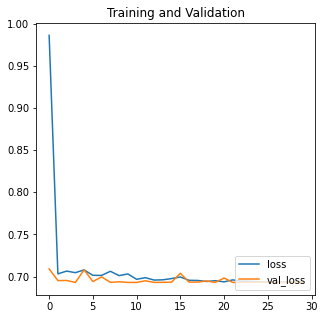

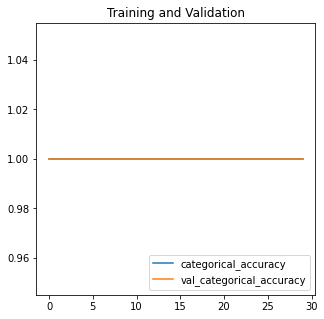

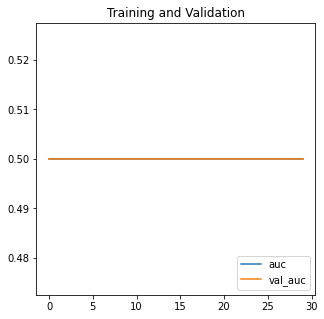

In [37]:
epochs_range = range(initial_epochs)
i = 0
for i in range(int(len(history.history.keys())/2)):
    key = list(history.history.keys())[i]
    
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 1, 1)
    plt.plot(epochs_range, history.history[key], label=key)
    plt.plot(epochs_range, history.history['val_' + key], label='val_' + key)
    plt.legend(loc='lower right')
    plt.title('Training and Validation')
plt.show()

## 2º Entrenamiento
Ahora vamos a entrenar tambien la red preentrenada, pero no queremos entrenar todas las capas, únicamente las capas más profundas, ya que las primeras capas son muy genéricas.

### Ajustar el entrenamiento de la red preentrenada

In [38]:
conv_base.trainable = True

In [39]:
len(conv_base.layers)

237

Vamos a entrenar desde la capa 100

In [40]:
fine_tune_at = 100

for layer in conv_base.layers[:fine_tune_at]:
    layer.trainable = False

## Hiperparámetros
Como el modelo es mucho más grande tenemos que usar un learning rate más bajo del que usabamos.
Vamos a utilizar dos learning rates, uno para el modelo preentrenado y otro para las capas nuevas

In [41]:
opt = [tf.keras.optimizers.Adam(learning_rate = lr), tf.keras.optimizers.RMSprop(learning_rate = lr/100)]
optimizers_and_layers = [(opt[0], model.layers[0]),
                         (opt[1], model.layers[1]),
                         (opt[0], model.layers[2:])]
opt = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

In [42]:
batch_size = 32
fine_tune_epochs = 50
total_epoch = initial_epochs + fine_tune_epochs

### Entrenamiento

In [43]:
model.compile(optimizer=opt, loss = loss , metrics = met)

In [44]:
history = model.fit(X_train,Y_train, 
                    batch_size = batch_size,
                    epochs = total_epoch,
                    initial_epoch=history.epoch[-1],
                    callbacks = tensorboard_callback,
                    validation_data = (X_test, Y_test))

Epoch 30/80
91/91 [==============================] - 85s 584ms/step - loss: 3.1409 - categorical_accuracy: 1.0000 - auc: 0.5000 - val_loss: 0.6933 - val_categorical_accuracy: 1.0000 - val_auc: 0.5000
Epoch 31/80
91/91 [==============================] - 27s 298ms/step - loss: 0.6938 - categorical_accuracy: 1.0000 - auc: 0.5000 - val_loss: 0.6937 - val_categorical_accuracy: 1.0000 - val_auc: 0.5000
Epoch 32/80
91/91 [==============================] - 28s 306ms/step - loss: 0.6944 - categorical_accuracy: 1.0000 - auc: 0.5000 - val_loss: 0.6932 - val_categorical_accuracy: 1.0000 - val_auc: 0.5000
Epoch 33/80
91/91 [==============================] - 28s 305ms/step - loss: 0.6941 - categorical_accuracy: 1.0000 - auc: 0.5000 - val_loss: 0.6932 - val_categorical_accuracy: 1.0000 - val_auc: 0.5000
Epoch 34/80
91/91 [==============================] - 28s 304ms/step - loss: 0.6938 - categorical_accuracy: 1.0000 - auc: 0.5000 - val_loss: 0.6932 - val_categorical_accuracy: 1.0000 - val_auc: 0.5000


KeyboardInterrupt: 

In [ ]:
epochs_range = len(history.history['loss'])
i = 0
for i in range(int(len(history.history.keys())/2)):
    key = list(history.history.keys())[i]
    
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 1, 1)
    plt.plot(history.history[key], label=key)
    plt.plot(history.history['val_' + key], label='val_' + key)
    plt.legend(loc='lower right')
    plt.title('Training and Validation')
plt.show()